# Model optimization

We will now define hyperparameter ranges for the top 4 models from the model evaluation step in `07_evaluation.ipynb`.

The models we choose are:

- **Logistic Regression:** Because it's fast, easy to interpret, and performs moderately well on the dataset. Accuracy `0.837`, F1-Score `0.822`.
- **Random Forest:** Because it handles non-linear relationships well and is robust to overfitting. The performance on the dataset was good. Accuracy `0.891`, F1-Score `0.881`.
- **SVM:** Because it can be effective in high-dimensional spaces and is versatile with different kernels. The performance on the dataset was good. Accuracy `0.865`, F1-Score `0.855`.
- **KNN:** Because it's simple and effective for smaller datasets, and it performed the best on the dataset. Accuracy `0.906`, F1-Score `0.897`.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_score,
    validation_curve,
)
from sklearn.model_selection import GridSearchCV
import pandas as pd
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt

X_train = pd.read_csv("../data/processed/X_train.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_val = pd.read_csv("../data/processed/y_val.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

target_variable = "tree_type"

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
}

models_with_hyperparameters = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],  # Inverse regularization
        "penalty": ["l2"],  # Regularization type
        "solver": ["liblinear", "saga"],  # Optimization algorithm
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [5, 10, 15, 20, None],  # Tree depth
        "min_samples_split": [2, 5, 10],  # Min samples to split
        "max_features": ["sqrt", "log2"],  # Features per split
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],  # Regularization strength
        "gamma": ["scale", "auto", 0.01, 0.1],  # Kernel coefficient
        "kernel": ["rbf", "linear", "poly"],  # Kernel type
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],  # Number of neighbors
        "weights": ["uniform", "distance"],  # Weight function
        "metric": ["euclidean", "manhattan"],  # Distance metric
    },
}

# Display hyperparameter ranges
for model_name, params in models_with_hyperparameters.items():
    print(f"\n{model_name} Hyperparameters:")
    for param, values in params.items():
        print(f"  {param}: {values}")


Logistic Regression Hyperparameters:
  C: [0.01, 0.1, 1, 10]
  penalty: ['l2']
  solver: ['liblinear', 'saga']

Random Forest Hyperparameters:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, 20, None]
  min_samples_split: [2, 5, 10]
  max_features: ['sqrt', 'log2']

SVM Hyperparameters:
  C: [0.1, 1, 10, 100]
  gamma: ['scale', 'auto', 0.01, 0.1]
  kernel: ['rbf', 'linear', 'poly']

KNN Hyperparameters:
  n_neighbors: [3, 5, 7, 9]
  weights: ['uniform', 'distance']
  metric: ['euclidean', 'manhattan']


## Using cross validation for single hyperparameter tuning

The downside of this approach is that it only uses one hyperparameter at a time and does not consider interactions between hyperparameters. 

In [2]:
def hyperparameter_cross_validation(model, params, X, y):
    """Test hyperparameter combinations with cross-validation"""

    # 5-fold stratified CV (maintains class proportions)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = {}

    for param_name, param_values in params.items():
        # If param_values is a list, iterate over each value
        if isinstance(param_values, list):
            for param_value in param_values:
                model.set_params(**{param_name: param_value})
                scores = cross_val_score(model, X, y, cv=cv, scoring="f1_weighted")
                results[f"{param_name}={param_value}"] = {
                    "mean": scores.mean(),
                    "std": scores.std(),
                    "scores": scores,
                }
                print(
                    f"{param_name}={param_value}: {scores.mean():.3f} ± {scores.std():.3f}"
                )
        else:
            # If param_values is not a list, just use it directly
            model.set_params(**{param_name: param_values})
            scores = cross_val_score(model, X, y, cv=cv, scoring="f1_weighted")
            results[f"{param_name}={param_values}"] = {
                "mean": scores.mean(),
                "std": scores.std(),
                "scores": scores,
            }
            print(
                f"{param_name}={param_values}: {scores.mean():.3f} ± {scores.std():.3f}"
            )

    return results


for model_name, model in models.items():
    print(f"\nOptimizing {model_name}...")
    if model_name in models_with_hyperparameters:
        params = models_with_hyperparameters[model_name]
        hyperparameter_cross_validation(
            model, params, X_train, y_train[target_variable]
        )
    else:
        print(f"No hyperparameters defined for {model_name}. Skipping...")


Optimizing Logistic Regression...
C=0.01: 0.832 ± 0.007
C=0.1: 0.829 ± 0.008
C=1: 0.835 ± 0.011
C=10: 0.834 ± 0.012
penalty=l2: 0.834 ± 0.012
solver=liblinear: 0.835 ± 0.012
solver=saga: 0.835 ± 0.011

Optimizing Random Forest...
n_estimators=50: 0.906 ± 0.007
n_estimators=100: 0.908 ± 0.006
n_estimators=200: 0.907 ± 0.008
max_depth=5: 0.851 ± 0.008
max_depth=10: 0.900 ± 0.005
max_depth=15: 0.906 ± 0.008
max_depth=20: 0.906 ± 0.005
max_depth=None: 0.907 ± 0.007
min_samples_split=2: 0.907 ± 0.009
min_samples_split=5: 0.905 ± 0.007
min_samples_split=10: 0.904 ± 0.006
max_features=sqrt: 0.904 ± 0.006
max_features=log2: 0.904 ± 0.006

Optimizing SVM...
C=0.1: 0.831 ± 0.012
C=1: 0.846 ± 0.013
C=10: 0.864 ± 0.016
C=100: 0.886 ± 0.010
gamma=scale: 0.886 ± 0.010
gamma=auto: 0.895 ± 0.009
gamma=0.01: 0.850 ± 0.015
gamma=0.1: 0.886 ± 0.010
kernel=rbf: 0.886 ± 0.010
kernel=linear: 0.835 ± 0.010
kernel=poly: 0.862 ± 0.010

Optimizing KNN...
n_neighbors=3: 0.915 ± 0.008
n_neighbors=5: 0.914 ± 0.01

## Grid Search Methodology

Now we will implement a grid search approach to systematically explore combinations of hyperparameters for each model. This method will help us identify the optimal set of hyperparameters that yield the best performance on our validation set.

In [3]:
def simple_grid_search(model, param_grid, X_train, y_train):
    """Basic grid search implementation"""

    # Create grid search object
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_weighted",  # Metric from M4L3 analysis
        n_jobs=-1,  # Use all CPU cores
        verbose=1,  # Show progress
    )

    # Fit and find best parameters
    grid_search.fit(X_train, y_train)

    print("Grid Search Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.3f}")
    print(f"Total combinations tested: {len(grid_search.cv_results_['params'])}")

    return grid_search


for model_name, model in models.items():
    print("\n")
    print("=" * 50)
    print(f"Running Grid Search for {model_name}...")
    if model_name in models_with_hyperparameters:
        params = models_with_hyperparameters[model_name]
        grid_search_result = simple_grid_search(
            model, params, X_train, y_train[target_variable]
        )
    else:
        print(f"No hyperparameters defined for {model_name}. Skipping...")



Running Grid Search for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search Results:
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best CV score: 0.834
Total combinations tested: 8


Running Grid Search for Random Forest...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Grid Search Results:
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.907
Total combinations tested: 90


Running Grid Search for SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Grid Search Results:
Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV score: 0.894
Total combinations tested: 48


Running Grid Search for KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Grid Search Results:
Best parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best CV score: 0.918
Total combinations tested: 1

## Random Search: Efficient Parameter Sampling

**Concept:** Random Search samples hyperparameter combinations randomly from specified distributions. Research shows it often finds good solutions faster than Grid Search, especially in high-dimensional parameter spaces where many parameters don't significantly affect performance.

This approach is useful when you have a large number of hyperparameters or when the fitting process is computationally expensive. Both is not the case here, but let's see how it works on the Random Forest model.

In [4]:
def simple_random_search(X_train, y_train):
    """Basic random search implementation"""

    # Define parameter distributions (more flexible than fixed grids)
    param_distributions = {
        "n_estimators": randint(50, 201),  # Random integers 50-200
        "max_depth": randint(3, 21),  # Random integers 3-20
        "min_samples_split": randint(2, 21),  # Random integers 2-20
        "min_samples_leaf": randint(1, 11),  # Random integers 1-10
        "max_features": ["sqrt", "log2", None],  # Random choice from list
    }

    # Create random search object
    random_search = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_distributions=param_distributions,
        n_iter=20,  # Number of random combinations to try
        cv=5,  # 5-fold cross-validation
        scoring="f1_weighted",
        n_jobs=-1,
        verbose=1,
        random_state=42,  # For reproducibility
    )

    # Fit and find best parameters
    random_search.fit(X_train, y_train)

    print("Random Search Results:")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.3f}")
    print(f"Combinations tested: {random_search.n_iter}")

    return random_search


simple_random_search(X_train, y_train[target_variable])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Random Search Results:
Best parameters: {'max_depth': 17, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
Best CV score: 0.904
Combinations tested: 20


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....t 0x109671310>, 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': <scipy.stats....t 0x12bdf8080>, 'min_samples_split': <scipy.stats....t 0x12bdfa540>, ...}"
,n_iter,20
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


## Bayesian Optimization: Smart Search for Expensive Functions

**Concept:** Bayesian Optimization uses probabilistic models to intelligently guide hyperparameter search, making informed decisions about which combinations to try next. This approach is particularly valuable when model training is computationally expensive.

Same as the for Random Search, it doesn't really make sense here since our models are not that expensive to train, therefore we will not implement it here.

## Early Stopping in Boosting & Neural Networks

**Concept:** Early stopping prevents overfitting by monitoring validation performance during training and stopping when performance begins to degrade. This technique is crucial for iterative algorithms like gradient boosting and neural networks that can overfit with too many iterations.

In [5]:
def proper_model_selection(
    model, param_grid, X_train, X_val, X_test, y_train, y_val, y_test
):
    """Proper model selection avoiding validation overfitting"""

    print(f"Data splits:")
    print(f"Training: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="f1_weighted", n_jobs=1)

    # Fit on train+validation
    grid_search.fit(X_train, y_train)

    # Final test (do this ONLY ONCE)
    final_score = grid_search.score(X_test, y_test)

    print(f"\nFinal Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"CV score: {grid_search.best_score_:.3f}")
    print(f"Final test score: {final_score:.3f}")

    return grid_search


for model_name, model in models.items():
    print("\n")
    print("=" * 50)
    print(f"Proper Model Selection for {model_name}...")
    if model_name in models_with_hyperparameters:
        params = models_with_hyperparameters[model_name]
        proper_model_selection(
            model,
            params,
            X_train,
            X_val,
            X_test,
            y_train[target_variable],
            y_val[target_variable],
            y_test[target_variable],
        )
    else:
        print(f"No hyperparameters defined for {model_name}. Skipping...")



Proper Model Selection for Logistic Regression...
Data splits:
Training: 4937 samples
Validation: 1646 samples
Test: 1646 samples

Final Results:
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
CV score: 0.834
Final test score: 0.842


Proper Model Selection for Random Forest...
Data splits:
Training: 4937 samples
Validation: 1646 samples
Test: 1646 samples

Final Results:
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
CV score: 0.908
Final test score: 0.903


Proper Model Selection for SVM...
Data splits:
Training: 4937 samples
Validation: 1646 samples
Test: 1646 samples

Final Results:
Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
CV score: 0.894
Final test score: 0.909


Proper Model Selection for KNN...
Data splits:
Training: 4937 samples
Validation: 1646 samples
Test: 1646 samples

Final Results:
Best parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
CV score: 0.

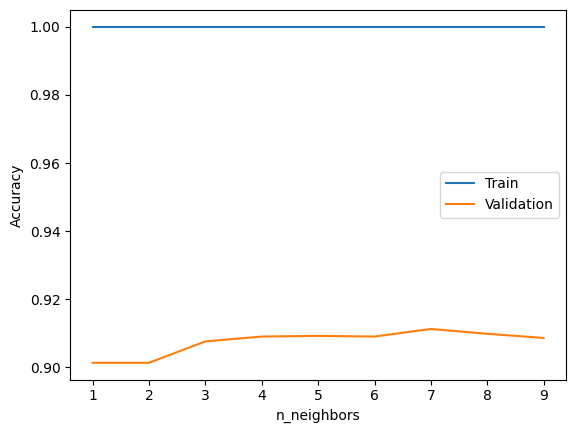

In [6]:
param_range = np.arange(1, 10, 1)

train_scores, val_scores = validation_curve(
    models["KNN"],
    X=X_train,
    y=y_train[target_variable],
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
)

plt.plot(param_range, train_scores.mean(axis=1), label="Train")
plt.plot(param_range, val_scores.mean(axis=1), label="Validation")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.show()